In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from pathlib import Path
from statsmodels.tsa.tsatools import detrend
import statsmodels.formula.api as sm
import itertools
import sys
import calendar
import datetime
# sns.set()
idx = pd.IndexSlice

### Date string for filenames
This will be inserted into all filenames (reading and writing)

In [3]:
file_date = '2018-03-06'

In [4]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [5]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [6]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

%aimport Plots.plot
from Plots.plot import region_facet_grid, rolling_corr_plot

## Load CO₂ intensity and percent gen data

### CO₂ intensity (aka *index*)

In [7]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data',
            'National index {}.csv'.format(file_date))
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [8]:
national_index.head()

,year,month,generation (mwh),elec fuel co2 (kg),final co2 (kg),index (g/kwh),datetime,quarter,index (lb/mwh),change since 2005,nerc
0,2001,1,3.324839e+08,2.110627e+11,2.145929e+11,645.423413,2001-01-01,1,1422.900456,0.077267,USA
1,2001,2,2.829402e+08,1.762658e+11,1.799442e+11,635.979511,2001-02-01,1,1402.080431,0.061504,USA
2,2001,3,3.007065e+08,1.860660e+11,1.887242e+11,627.602684,2001-03-01,1,1383.612877,0.047523,USA
3,2001,4,2.780781e+08,1.717565e+11,1.744977e+11,627.513263,2001-04-01,2,1383.415739,0.047373,USA
4,2001,5,3.004857e+08,1.859817e+11,1.888085e+11,628.344387,2001-05-01,2,1385.248036,0.048761,USA


In [9]:
path = join(cwd, '..', 'Data storage',
            'final NERC data',
            'NERC gen emissions and index {}.csv'.format(file_date))
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

In [10]:
nerc_index.head()

,year,nerc,month,final co2 (kg),generation (mwh),index (g/kwh),datetime
0,2001,ASCC,1,2.776167e+08,509509.093,544.870957,2001-01-01
1,2001,ASCC,2,2.687019e+08,456570.631,588.522012,2001-02-01
2,2001,ASCC,3,2.937043e+08,492752.208,596.048720,2001-03-01
3,2001,ASCC,4,2.354016e+08,416745.544,564.856988,2001-04-01
4,2001,ASCC,5,2.303100e+08,408946.508,563.178907,2001-05-01


### Percent generation

In [11]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National percent gen {}.csv'.format(file_date))
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'
national_per_gen.rename(columns={'generation (mwh)': '% generation'},
                        inplace=True)

In [12]:
national_per_gen.head()

,year,month,fuel category,elec fuel co2 (kg),% generation,datetime,nerc
0,2001,1,Coal,0.0,0.533220,2001-01-01,USA
1,2001,2,Coal,0.0,0.529212,2001-02-01,USA
2,2001,3,Coal,0.0,0.516347,2001-03-01,USA
3,2001,4,Coal,0.0,0.505867,2001-04-01,USA
4,2001,5,Coal,0.0,0.504493,2001-05-01,USA


In [13]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC percent gen {}.csv'.format(file_date))
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])

In [14]:
nerc_per_gen.head()

,fuel category,datetime,nerc,% generation
0,Coal,2001-01-01,ASCC,0.051998
1,Coal,2001-02-01,ASCC,0.068475
2,Coal,2001-03-01,ASCC,0.057757
3,Coal,2001-04-01,ASCC,0.049085
4,Coal,2001-05-01,ASCC,0.058924


### Absolute generation

In [15]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National generation {}.csv'.format(file_date))
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [16]:
national_gen.tail()

,fuel category,year,month,generation (mwh),datetime,nerc
1627,Wind,2017,8,13064719.50,2017-08-01,USA
1628,Wind,2017,9,17264878.55,2017-09-01,USA
1629,Wind,2017,10,24814868.01,2017-10-01,USA
1630,Wind,2017,11,23315592.47,2017-11-01,USA
1631,Wind,2017,12,22757913.41,2017-12-01,USA


In [17]:
index_cols = ['nerc', 'generation (mwh)', 'datetime']
nerc_gen = pd.merge(nerc_per_gen, nerc_index[index_cols],
                    on=['nerc', 'datetime'])
nerc_gen.rename(columns={'generation (mwh)' : 'total generation (mwh)'},
                inplace=True)
nerc_gen['generation (mwh)'] = (nerc_gen['% generation']
                                * nerc_gen['total generation (mwh)'])
nerc_gen.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)
nerc_gen.head()

% generation  total generation (mwh)  \
nerc fuel category datetime                                           
ASCC Coal          2001-01-01      0.051998              509509.093   
     Hydro         2001-01-01      0.204001              509509.093   
     Natural Gas   2001-01-01      0.616685              509509.093   
     Other         2001-01-01      0.127146              509509.093   
     Wind          2001-01-01      0.000170              509509.093   

                               generation (mwh)  
nerc fuel category datetime                      
ASCC Coal          2001-01-01         26493.302  
     Hydro         2001-01-01        103940.302  
     Natural Gas   2001-01-01        314206.726  
     Other         2001-01-01         64782.245  
     Wind          2001-01-01            86.518

#### Add generation by different fuel sources to get total generation by NERC

In [18]:
total = nerc_gen.groupby(['nerc', 'datetime'])['% generation',
                                               'generation (mwh)'].sum()
total['fuel category'] = 'Total'
total.set_index('fuel category', append=True, inplace=True)
total = total.reorder_levels(['nerc', 'fuel category', 'datetime'])
total.head()

% generation  generation (mwh)
nerc fuel category datetime                                  
ASCC Total         2001-01-01           1.0        509509.093
                   2001-02-01           1.0        456570.631
                   2001-03-01           1.0        492752.208
                   2001-04-01           1.0        416745.544
                   2001-05-01           1.0        408946.508

In [19]:
nerc_gen = pd.concat([nerc_gen, total])
nerc_gen.sort_index(inplace=True)

In [20]:
nerc_gen.head()

% generation  generation (mwh)  \
nerc fuel category datetime                                     
ASCC Coal          2001-01-01      0.051998         26493.302   
                   2001-02-01      0.068475         31263.704   
                   2001-03-01      0.057757         28459.894   
                   2001-04-01      0.049085         20455.924   
                   2001-05-01      0.058924         24096.734   

                               total generation (mwh)  
nerc fuel category datetime                            
ASCC Coal          2001-01-01              509509.093  
                   2001-02-01              456570.631  
                   2001-03-01              492752.208  
                   2001-04-01              416745.544  
                   2001-05-01              408946.508

## Load capacity by month, fuel, nerc

In [21]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Plant Capacity', 'monthly capacity by fuel.csv')

capacity = pd.read_csv(path, index_col=['nerc', 'fuel category', 'datetime'],
                       parse_dates=['datetime'])
capacity.drop(['year', 'month'], axis=1, inplace=True)

In [22]:
capacity.head()

active capacity  possible gen
nerc fuel category datetime                                 
ASCC Coal          2001-01-01            117.5       87420.0
                   2001-02-01            117.5       78960.0
                   2001-03-01            117.5       87420.0
                   2001-04-01            117.5       84600.0
                   2001-05-01            117.5       87420.0

In [23]:
national_capacity = capacity.groupby(['fuel category', 'datetime']).sum()
national_capacity['nerc'] = 'USA'
national_capacity.set_index('nerc', append=True, inplace=True)
national_capacity = national_capacity.reorder_levels(['nerc', 'fuel category', 'datetime'])
national_capacity.head()

active capacity  possible gen
nerc fuel category datetime                                 
USA  Coal          2001-01-01         325145.5   241908252.0
                   2001-02-01         325145.5   218497776.0
                   2001-03-01         325145.5   241908252.0
                   2001-04-01         325659.2   234474624.0
                   2001-05-01         325659.2   242290444.8

In [24]:
capacity = pd.concat([capacity, national_capacity])
capacity.sort_index(inplace=True)
capacity.tail()

active capacity  possible gen
nerc fuel category datetime                                 
WECC Wind          2017-08-01          19994.6    14875982.4
                   2017-09-01          19994.6    14396112.0
                   2017-10-01          19994.6    14875982.4
                   2017-11-01          19994.6    14396112.0
                   2017-12-01          19994.6    14875982.4

## Combine NERC and national results

### CO₂ intensity

In [25]:
index = pd.concat([national_index, nerc_index])

In [26]:
index.head()

,change since 2005,datetime,elec fuel co2 (kg),final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.077267,2001-01-01,2.110627e+11,2.145929e+11,3.324839e+08,645.423413,1422.900456,1,USA,1.0,2001
1,0.061504,2001-02-01,1.762658e+11,1.799442e+11,2.829402e+08,635.979511,1402.080431,2,USA,1.0,2001
2,0.047523,2001-03-01,1.860660e+11,1.887242e+11,3.007065e+08,627.602684,1383.612877,3,USA,1.0,2001
3,0.047373,2001-04-01,1.717565e+11,1.744977e+11,2.780781e+08,627.513263,1383.415739,4,USA,2.0,2001
4,0.048761,2001-05-01,1.859817e+11,1.888085e+11,3.004857e+08,628.344387,1385.248036,5,USA,2.0,2001


### Percent generation

In [27]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])

per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [28]:
per_gen.head()

,% generation,datetime,elec fuel co2 (kg),fuel category,month,nerc,year
0,0.533220,2001-01-01,0.0,Coal,1,USA,2001
1,0.529212,2001-02-01,0.0,Coal,2,USA,2001
2,0.516347,2001-03-01,0.0,Coal,3,USA,2001
3,0.505867,2001-04-01,0.0,Coal,4,USA,2001
4,0.504493,2001-05-01,0.0,Coal,5,USA,2001


### Total generation

In [29]:
national_gen.head()

,fuel category,year,month,generation (mwh),datetime,nerc
0,Coal,2001,1,177287111.0,2001-01-01,USA
1,Coal,2001,2,149735483.0,2001-02-01,USA
2,Coal,2001,3,155269010.0,2001-03-01,USA
3,Coal,2001,4,140670652.0,2001-04-01,USA
4,Coal,2001,5,151592915.0,2001-05-01,USA


In [30]:
cols = ['nerc', 'fuel category', 'datetime']
gen = pd.concat([national_gen.set_index(cols), nerc_gen])
gen.sort_index(inplace=True)
gen.drop(['% generation', 'total generation (mwh)'], axis=1,
         inplace=True)

In [31]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

## Figures

In [32]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('paper', font_scale=1.2)

### Total generation

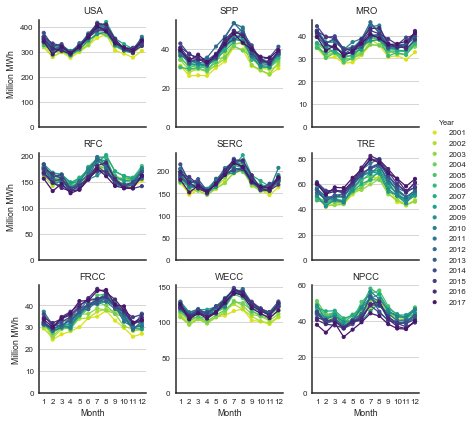

In [35]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['generation (mwh)'] /= 1E6

# temp.rename(columns={'month': 'Month',
#                      'year': 'Year'}, inplace=True)
with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='generation (mwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2, sharey=False)
    
    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, None)
        
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Million MWh')
            
path = join(cwd, '..', 'Figures', 'Monthly generation {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

### Index figure

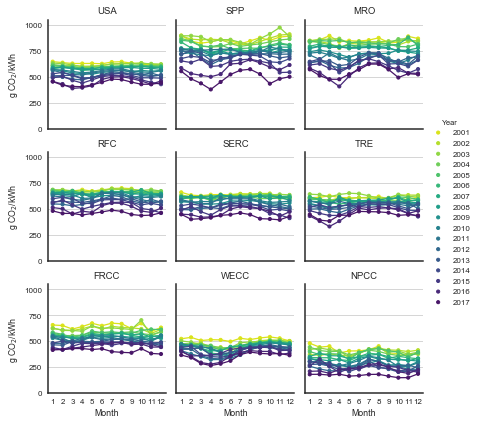

In [36]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures',
            'Monthly index (12-months) {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

#### Alternate plot of CO₂ intensity

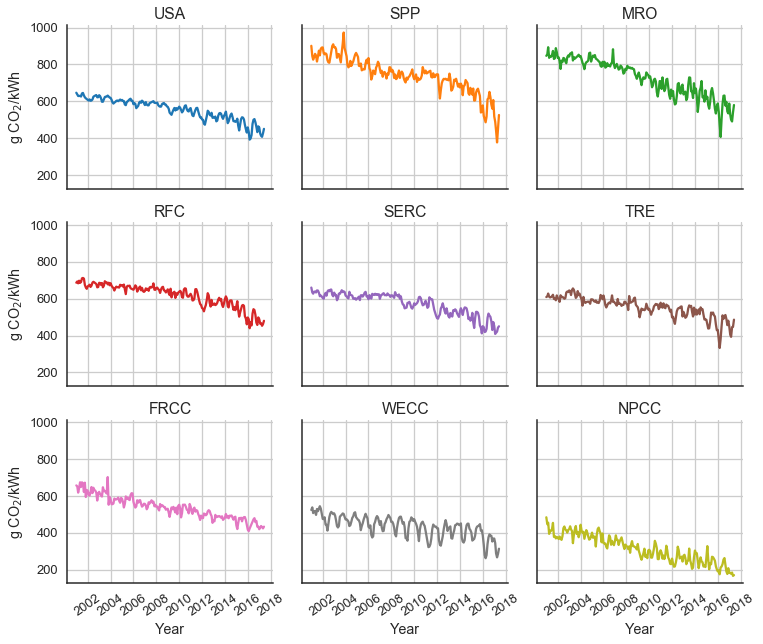

In [47]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index by region.pdf')
plt.savefig(path, bbox_inches='tight')

In [29]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


#### Plot of detrended intensity, using a linear detrend
Not a good method - trend isn't linear

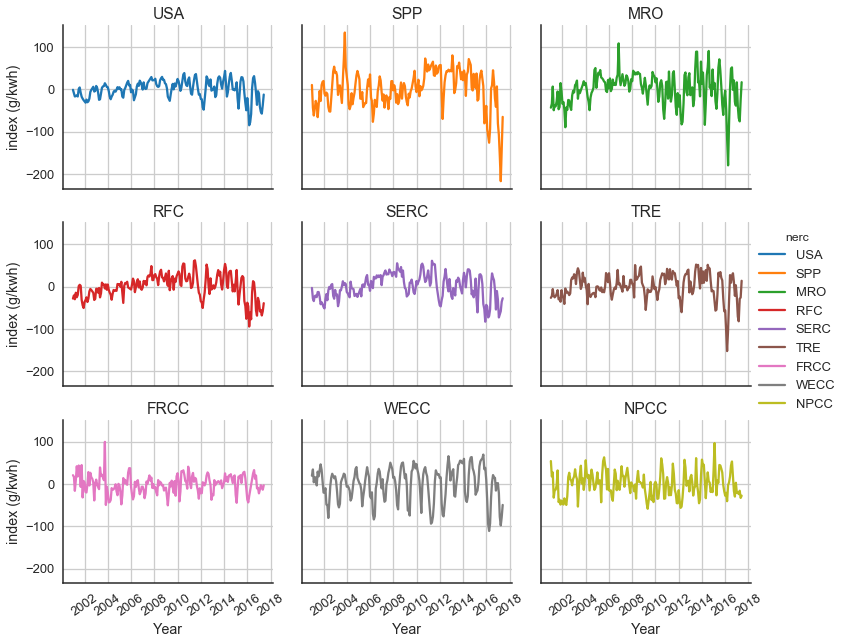

In [48]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend
Better than linear, but I'm not sure it's appropriate

In [49]:
def diff_detrend(series, n=1):
    d = series - series.shift(n)
    return d

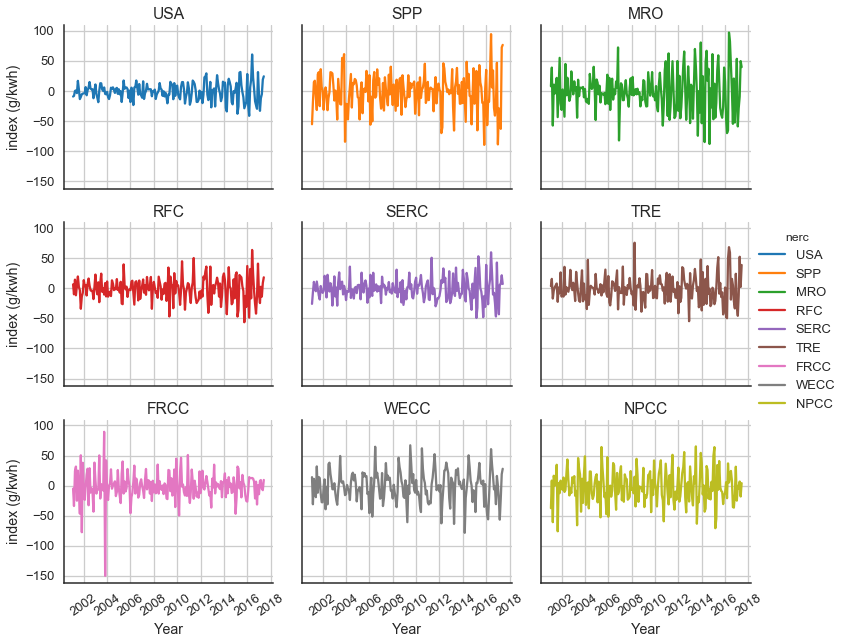

In [50]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Detrend by subtracting the rolling 1-year mean

Started by using `seasonal_decompose` from statsmodels. It was apparent that the `trend` component is just the rolling average. I'm leaving the extra code here as documentation of this fact.

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [53]:
wecc = index.loc[index['nerc'] == 'WECC', ['index (g/kwh)', 'datetime']]
wecc.set_index('datetime', inplace=True)
wecc.head()

,index (g/kwh)
datetime,
2001-01-01,524.331566
2001-02-01,538.398535
2001-03-01,507.408432
2001-04-01,518.650607
2001-05-01,517.016964


In [54]:
sd = seasonal_decompose(wecc)

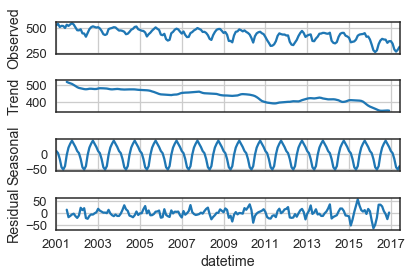

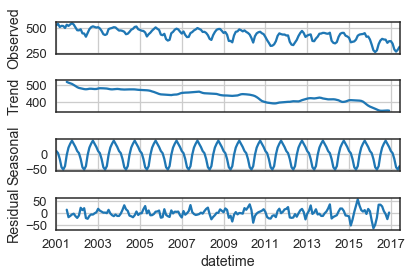

In [55]:
sd.plot()

These three things are all the same:
1. Subtracting just the *trend* from the `WECC` data
2. Adding the *seasonal* and *resid* components
3. Subtracting the annual rolling mean from the `WECC` data

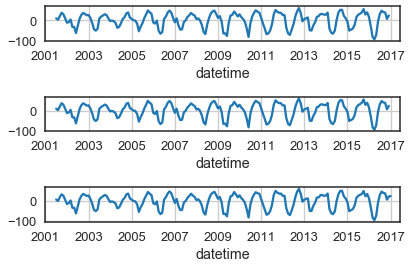

In [56]:
fig, ax = plt.subplots(nrows=3, squeeze=True)
(wecc - sd.trend).plot(ax=ax[0], legend=False)
(sd.seasonal + sd.resid).plot(ax=ax[1], legend=False)
(wecc - wecc.rolling(12, center=True).mean()).plot(ax=ax[2], legend=False)
plt.tight_layout()

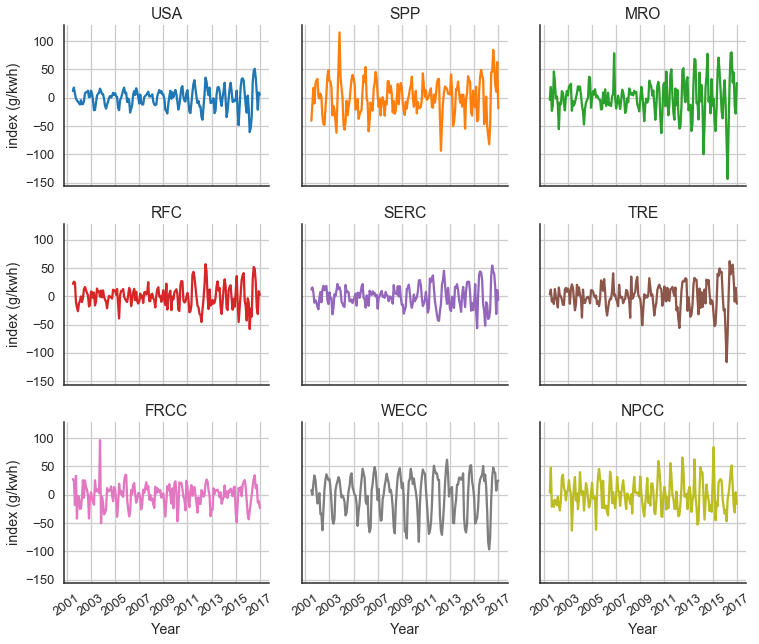

In [57]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Create a combined figure for the SI
Include the raw monthly data, the rolling mean trend line, and the detrended data

In [38]:
temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

In [39]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.077477,2001-01-01,2.142842e+11,3.324839e+08,644.494871,1420.853394,1,USA,1.0,2001
1,0.061603,2001-02-01,1.796670e+11,2.829402e+08,635.000010,1399.921021,2,USA,1.0,2001
2,0.047543,2001-03-01,1.884196e+11,3.007065e+08,626.589712,1381.379680,3,USA,1.0,2001
3,0.047411,2001-04-01,1.742190e+11,2.780781e+08,626.510901,1381.205933,4,USA,2.0,2001
4,0.048812,2001-05-01,1.885094e+11,3.004857e+08,627.348927,1383.053445,5,USA,2.0,2001


In [40]:
detrend_index.head()

,index (g/kwh),nerc
datetime,,
2001-01-01,NaN,USA
2001-02-01,NaN,USA
2001-03-01,NaN,USA
2001-04-01,NaN,USA
2001-05-01,NaN,USA


In [41]:
combined = index.copy()
combined.set_index(['nerc', 'datetime'], inplace=True)
df = detrend_index.reset_index(drop=False).set_index(['nerc', 'datetime'])
df.columns = ['detrend index']

In [42]:
combined = pd.concat([index.set_index(['nerc', 'datetime']), df])

In [43]:
combined.head()

change since 2005  detrend index  final co2 (kg)  \
nerc datetime                                                       
USA  2001-01-01           0.077477            NaN    2.142842e+11   
     2001-02-01           0.061603            NaN    1.796670e+11   
     2001-03-01           0.047543            NaN    1.884196e+11   
     2001-04-01           0.047411            NaN    1.742190e+11   
     2001-05-01           0.048812            NaN    1.885094e+11   

                 generation (mwh)  index (g/kwh)  index (lb/mwh)  month  \
nerc datetime                                                             
USA  2001-01-01      3.324839e+08     644.494871     1420.853394    1.0   
     2001-02-01      2.829402e+08     635.000010     1399.921021    2.0   
     2001-03-01      3.007065e+08     626.589712     1381.379680    3.0   
     2001-04-01      2.780781e+08     626.510901     1381.205933    4.0   
     2001-05-01      3.004857e+08     627.348927     1383.053445    5.0   

                 quarter    year  
nerc datetime                     
USA  2001-01-01      1.0  2001.0  
     2001-02-01      1.0  2001.0  
     2001-03-01      1.0  2001.0  
     2001-04-01      2.0  2001.0  
     2001-05-01      2.0  2001.0

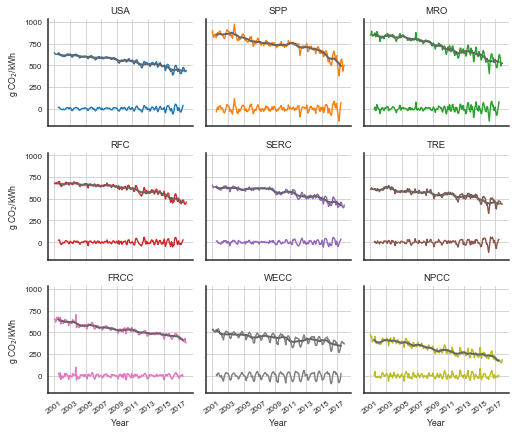

In [45]:
def plot_trend(x, y, **kws):
    'Plot function for the FacetGrid to plot all three data series'
    trend = y.rolling(12, center=True).mean()
    plt.plot(x, y, **kws)
    plt.plot(x, trend, lw=2, c='0.4')
    detrended = y - trend
    plt.plot(x, detrended, **kws)

order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10',
                 size=2)

region_facet_grid(df=index.reset_index(), plot_function=plot_trend, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='paper', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI',
            'Monthly index trend and detrended by region {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

### Percent gen figures

#### Color palette for fuel categories
Use the Tableau 10 color palette

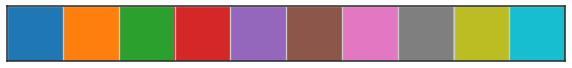

In [64]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

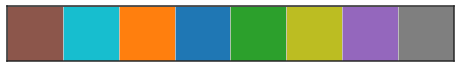

In [40]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

In [66]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

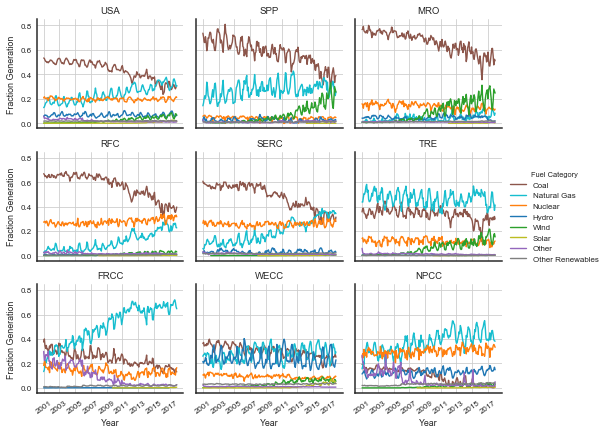

In [47]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette,
                 size=2)

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='% generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  y_label='Fraction Generation',
                  context='paper', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## Capacity factor of each fuel by month

In [53]:
capacity['Capacity Factor'] = (gen.loc[:, 'generation (mwh)'] 
                               / capacity.loc[:, 'possible gen'])

In [54]:
capacity.tail()

active capacity  possible gen  Capacity Factor
nerc fuel category datetime                                                  
WECC Wind          2017-08-01          19994.6    14875982.4         0.180604
                   2017-09-01          19994.6    14396112.0         0.193200
                   2017-10-01          19994.6    14875982.4         0.260755
                   2017-11-01          19994.6    14396112.0         0.242742
                   2017-12-01          19994.6    14875982.4         0.211559

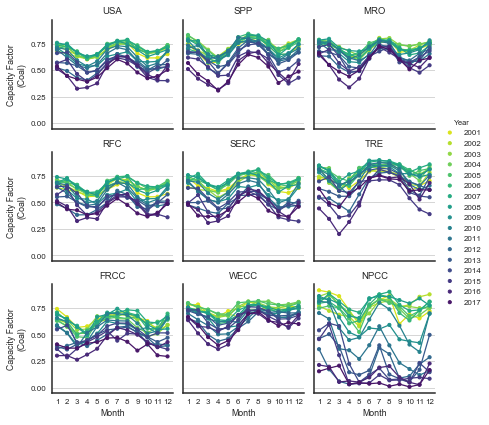

In [55]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor\n(Coal)')
            
path = join(cwd, '..', 'Figures', 'SI', 'Monthly Coal CF {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

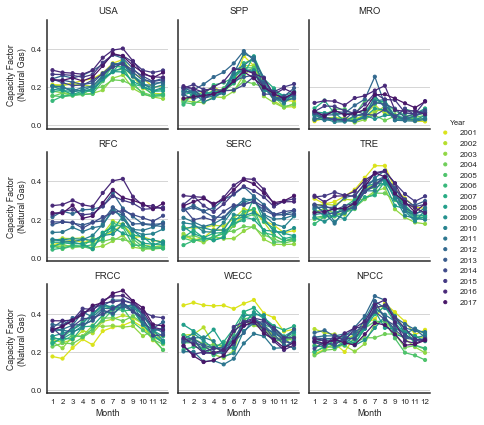

In [56]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor\n(Natural Gas)')
            
path = join(cwd, '..', 'Figures', 'SI', 'Monthly Natural Gas CF {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

In [44]:
def monthly_fuel_gen(gen_df, fuel, folder, file_type='pdf', dpi=350, save=False):
    """
    Make a FacetGrid plot of monthly generation for a single fuel category
    
    inputs:
        gen_df (dataframe): monthly generation for all fuels
        fuel (string): name of the fuel category to plot
        folder (path): folder where the plot should be saved
        file_type (string): file format (e.g. pdf, png, etc)
        dpi (int): dots per inch resolution for saved file (if not pdf)
        save (bool): if True, save the file
            
    """
    order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
    temp = gen.loc[idx[:, fuel, :], :].reset_index()
    temp['Month'] = temp['datetime'].dt.month
    temp['Year'] = temp['datetime'].dt.year
    temp['million mwh'] = temp['generation (mwh)'] / 1e6

    with sns.plotting_context('paper', font_scale=1):

        g = sns.factorplot(x='Month', y='million mwh', hue='Year', sharey=False,
                           data=temp, col='nerc', col_wrap=3, col_order=order, 
                           palette='viridis_r', scale=0.5, size=2)

        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
            ax.set_ylim(0, None)
    #         ax.set_ylim(0, 1050)
            if title in ['USA', 'RFC', 'FRCC']:
                ax.set_ylabel('Million MWh\n({})'.format(fuel))

    path = join(folder, 'Monthly {} gen {}.{}'.format(fuel, file_date, file_type))
    if save:
        plt.savefig(path, bbox_inches='tight', dpi=dpi)
    
    

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Coal gen 2018-03-06.pdf


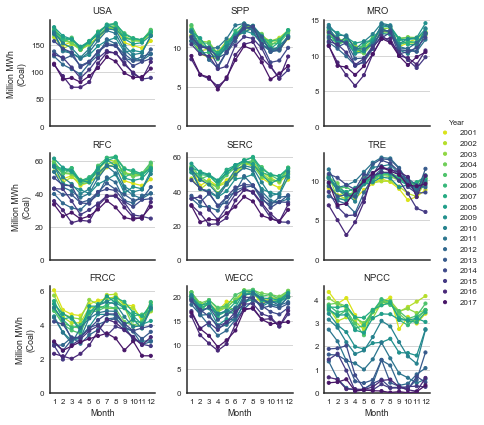

In [46]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Coal', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Natural Gas gen 2018-03-06.pdf


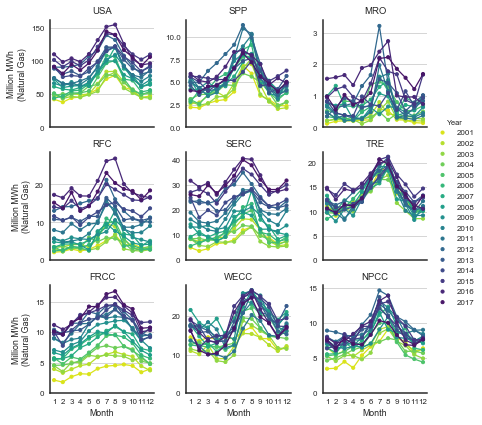

In [45]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Natural Gas', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Nuclear gen 2018-03-06.pdf


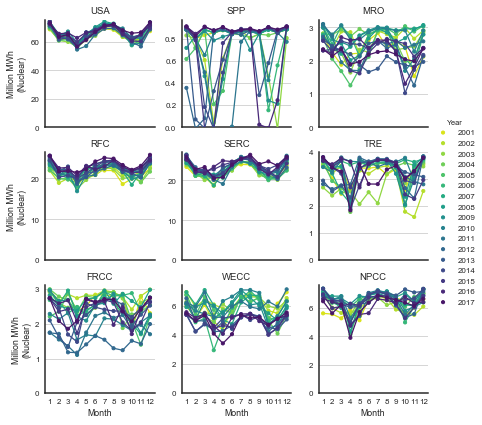

In [47]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Nuclear', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Wind gen 2018-03-06.pdf


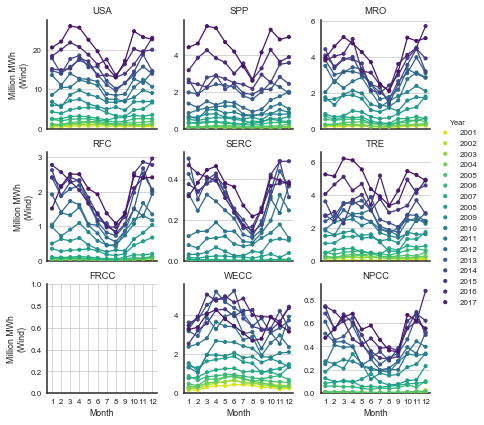

In [48]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Wind', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Solar gen 2018-03-06.pdf


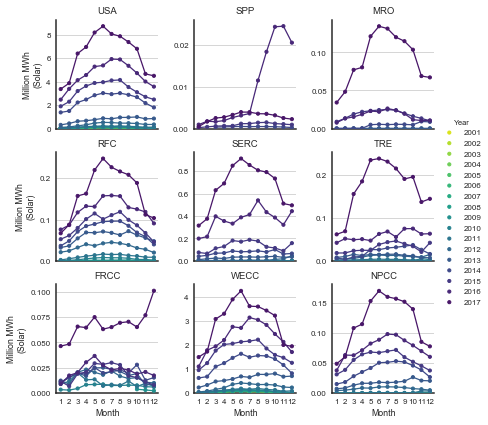

In [49]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Solar', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Other gen 2018-03-06.pdf


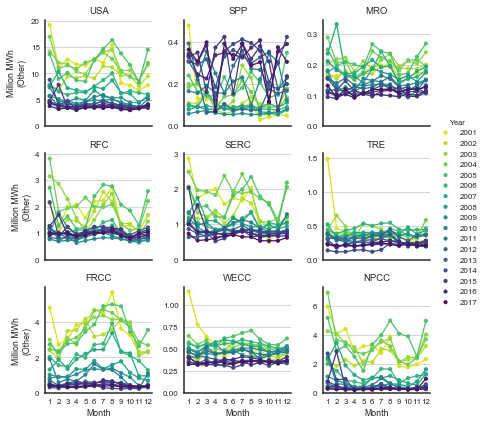

In [50]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Other', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Other Renewables gen 2018-03-06.pdf


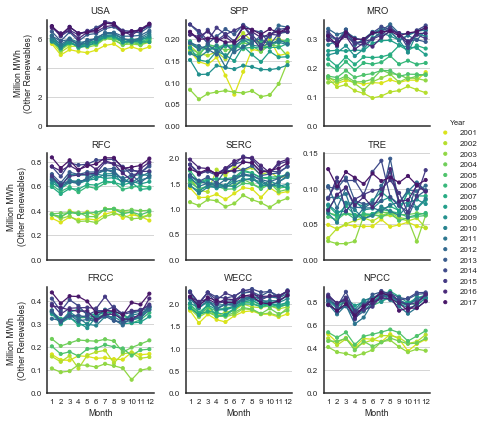

In [51]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Other Renewables', folder=folder_path, file_type='pdf', save=True)

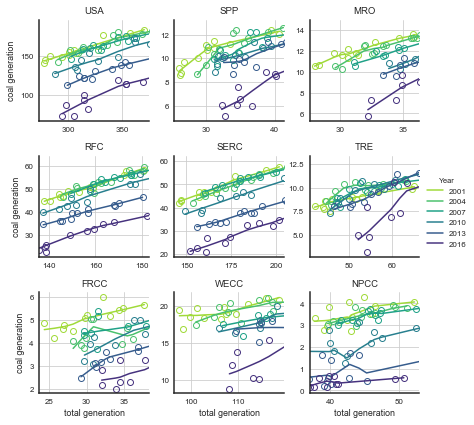

In [36]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
years = range(2001, 2017, 3)
temp = gen.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['coal generation'] = temp['generation (mwh)'] / 1e6
temp = temp.loc[temp['Year'].isin(years), :]

total_gen = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
total_gen.rename(columns={'generation (mwh)': 'total generation'}, inplace=True)
total_gen['total generation'] /= 1e6

temp = temp.merge(total_gen, on=['nerc', 'datetime'])

def scatter_coal_total(x, y, *args, **kwargs):
    plt.plot(x, y, 'o', markersize=6, markeredgewidth=1, markerfacecolor='None', **kwargs)
    line_kws = dict(linewidth=1.5)
    sns.regplot(x, y, x_ci=None, lowess=True, n_boot=1, line_kws=line_kws,
                scatter=False, **kwargs)

with sns.plotting_context('paper', font_scale=1):

    g = sns.FacetGrid(data=temp, hue='Year', sharey=False, sharex=False,
                      col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', size=2)
    g.map(scatter_coal_total, 'total generation', 'coal generation')
    g.add_legend()

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
#         if title in ['USA', 'RFC', 'FRCC']:
#             ax.set_ylabel('Million MWh Coal')
            
path = join(cwd, '..', 'Figures', 'Total vs coal gen {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## Figure of wind, nat gas, and coal
Show how generation from these three resources has changed over time in SPP, TRE, and MRO.

In [58]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

,% generation,datetime,fuel category,month,nerc,year
3627,0.749081,2005-01-01,Coal,1,MRO,2005
3628,0.755946,2005-02-01,Coal,2,MRO,2005
3629,0.754638,2005-03-01,Coal,3,MRO,2005
3630,0.752165,2005-04-01,Coal,4,MRO,2005
3631,0.750231,2005-05-01,Coal,5,MRO,2005


In [59]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
ASCC 2001-01-01      0                NaN    2.776167e+08        509509.093   
     2001-02-01      1                NaN    2.687019e+08        456570.631   
     2001-03-01      2                NaN    2.937043e+08        492752.208   
     2001-04-01      3                NaN    2.354016e+08        416745.544   
     2001-05-01      4                NaN    2.303100e+08        408946.508   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
ASCC 2001-01-01     544.870957             NaN      1      NaN  2001  
     2001-02-01     588.522012             NaN      2      NaN  2001  
     2001-03-01     596.048720             NaN      3      NaN  2001  
     2001-04-01     564.856988             NaN      4      NaN  2001  
     2001-05-01     563.178907             NaN      5      NaN  2001

In [209]:
capacity.head()

active capacity  possible gen  Capacity Factor
nerc fuel category datetime                                                  
ASCC Coal          2001-01-01            117.5       87420.0         0.303058
                   2001-02-01            117.5       78960.0         0.395944
                   2001-03-01            117.5       87420.0         0.325554
                   2001-04-01            117.5       84600.0         0.241796
                   2001-05-01            117.5       87420.0         0.275643

In [61]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    'Add classifications to each month based on the year'
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2017'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index.reset_index()[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, '% generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

temp_df = temp_df.merge(capacity.reset_index(), how='left',
                        on=['nerc', 'fuel category', 'datetime'])

In [62]:
temp_df.head()

,% generation,datetime,fuel category,month,nerc,year,timeframe,generation (mwh),generation,active capacity,possible gen,Capacity Factor
0,0.749081,2005-01-01,Coal,1,MRO,2005,2005-2008,1.818534e+07,13.622289,23272.1,17314442.4,0.786759
1,0.028732,2005-01-01,Natural Gas,1,MRO,2005,2005-2008,1.818534e+07,0.522503,13377.9,9953157.6,0.052496
2,0.012269,2005-01-01,Wind,1,MRO,2005,2005-2008,1.818534e+07,0.223117,1348.2,1003060.8,0.222436
3,0.755946,2005-02-01,Coal,2,MRO,2005,2005-2008,1.513040e+07,11.437763,23272.1,15638851.2,0.731369
4,0.032427,2005-02-01,Natural Gas,2,MRO,2005,2005-2008,1.513040e+07,0.490631,13377.9,8989948.8,0.054575


In [63]:
# a is the list of colors
# Matching fuel colors to the generation plot above
a = fuel_palette[0:2]
a.append(fuel_palette[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


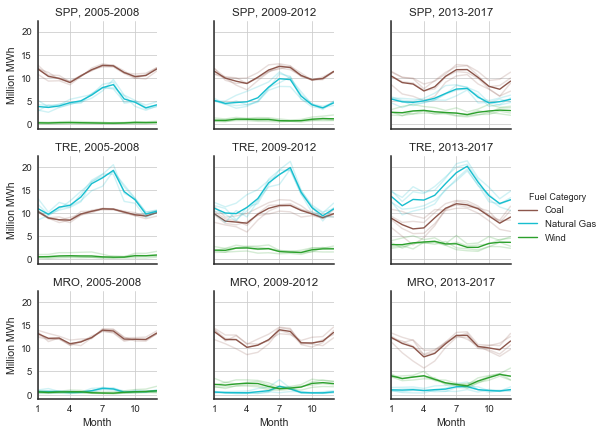

In [66]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2017']

with sns.plotting_context(font_scale=1):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.2,
                      size=2)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures',
            'Wind-Coal-NG variability tsplot {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

In [46]:
rolling_var_list = []
for nerc in ['TRE', 'SPP', 'MRO']:
    for fuel in ['Coal', 'Natural Gas', 'Wind']:
        _df = temp_df.loc[(temp_df['nerc'] == nerc) &
                          (temp_df['fuel category'] == fuel),
                         ['nerc', 'fuel category', 'datetime', 'generation']]
        _df['variability'] = (_df['generation']
                              .rolling(24, center=True)
                              .std())
        
        rolling_var_list.append(_df)
        
rolling_var_df = pd.concat(rolling_var_list)

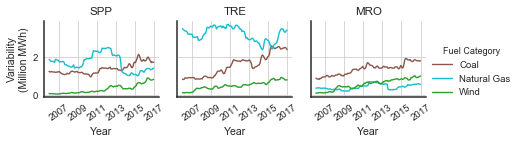

In [48]:
g = sns.FacetGrid(rolling_var_df, hue='fuel category', col='nerc', 
                  col_order=['SPP', 'TRE', 'MRO'], palette=a, size=2)
g.map(plt.plot, 'datetime', 'variability').add_legend(title='Fuel Category')
g.set_xticklabels(rotation=35)

g.set_axis_labels('Year', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)

path = join(cwd, '..', 'Figures', 'SI',
            'Wind-Coal-NG rolling variability {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

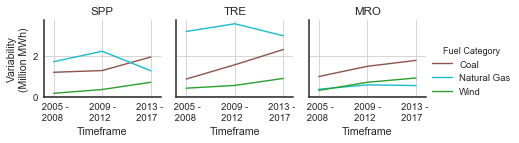

In [67]:
# Map quantitative values to the timeframes to make plotting easier
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2017': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
               .std()
               .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a, size=2)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2017   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures',
            'Wind-Coal-NG variability {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [51]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('RFC', 'MRO'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [52]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

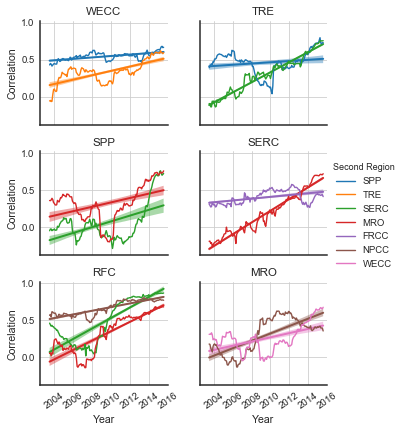

In [54]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                       detrend_series=True, seasonal=True, fill_alpha=0.4)
path = join(cwd, '..', 'Figures',
            '_Rolling correlation - seasonal detrend 48m centered {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

#### Additional rolling windows for comparison and the SI

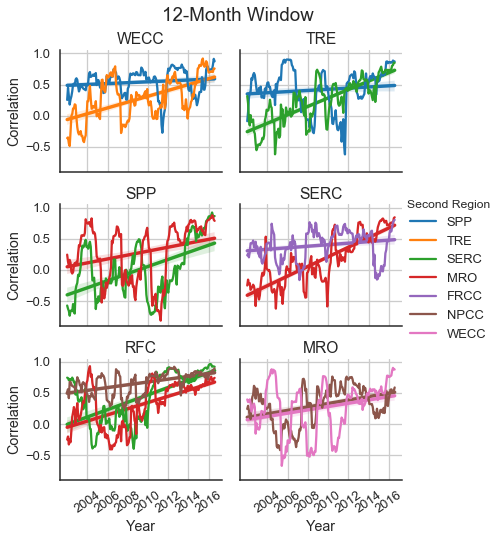

In [85]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12,
                  detrend_series=True, seasonal=True,
                  sup_title='12-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 12m centered.pdf')
plt.savefig(path, bbox_inches='tight')

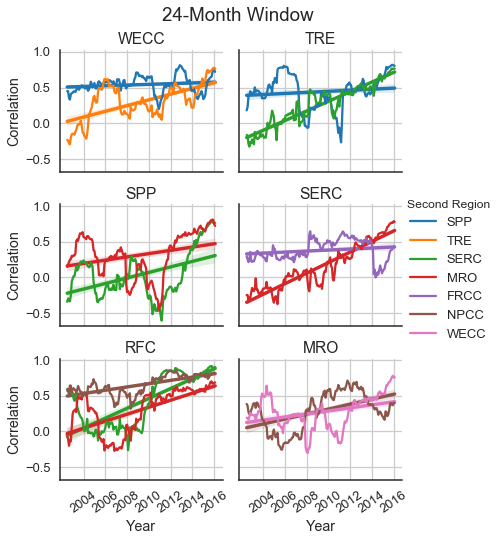

In [86]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24,
                  detrend_series=True, seasonal=True,
                  sup_title='24-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 24m centered.pdf')
plt.savefig(path, bbox_inches='tight')

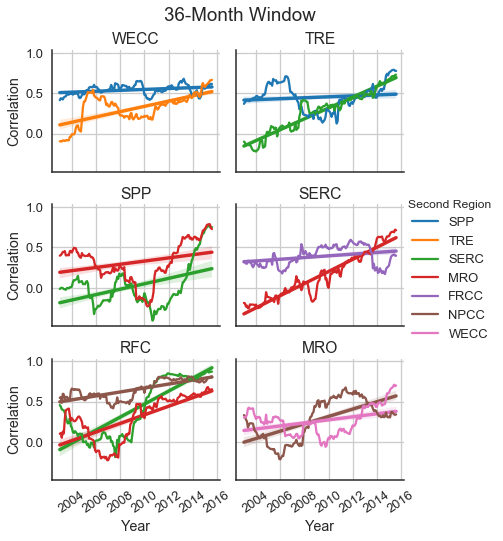

In [87]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36,
                  detrend_series=True, seasonal=True, 
                  sup_title='36-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 36m centered.pdf')
plt.savefig(path, bbox_inches='tight')

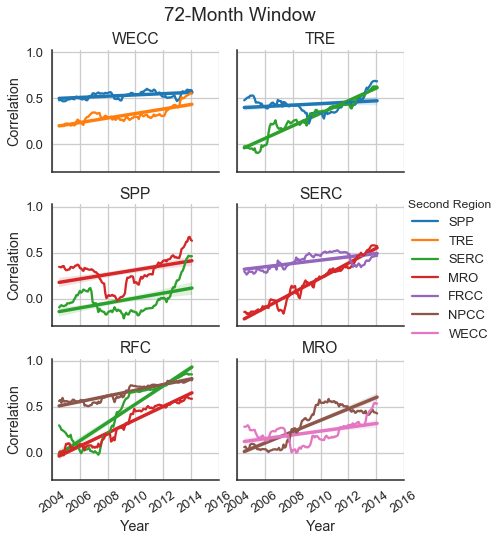

In [88]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72,
                  detrend_series=True, seasonal=True,
                  sup_title='72-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 72m centered.pdf')
plt.savefig(path, bbox_inches='tight')

## Changes in CO₂ intensity for each NERC region

In [32]:
index.head()

,change since 2005,datetime,elec fuel co2 (kg),final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.077267,2001-01-01,2.110627e+11,2.145929e+11,3.324839e+08,645.423413,1422.900456,1,USA,1.0,2001
1,0.061504,2001-02-01,1.762658e+11,1.799442e+11,2.829402e+08,635.979511,1402.080431,2,USA,1.0,2001
2,0.047523,2001-03-01,1.860660e+11,1.887242e+11,3.007065e+08,627.602684,1383.612877,3,USA,1.0,2001
3,0.047373,2001-04-01,1.717565e+11,1.744977e+11,2.780781e+08,627.513263,1383.415739,4,USA,2.0,2001
4,0.048761,2001-05-01,1.859817e+11,1.888085e+11,3.004857e+08,628.344387,1385.248036,5,USA,2.0,2001


In [34]:
annual_index = (index#.drop('index', axis=1)
                     #.reset_index()
                     .groupby(['year', 'nerc'])
                     .sum())
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.sort_index(inplace=True)

In [35]:
annual_index.head()

change since 2005  elec fuel co2 (kg)  final co2 (kg)  \
year nerc                                                          
2001 ASCC                0.0                 0.0    3.064312e+09   
     FRCC                0.0                 0.0    1.179943e+11   
     HICC                0.0                 0.0    8.294079e+09   
     MRO                 0.0                 0.0    1.620815e+11   
     NPCC                0.0                 0.0    1.071093e+11   

           generation (mwh)  index (g/kwh)  index (lb/mwh)  month  quarter  
year nerc                                                                   
2001 ASCC      5.517773e+06     555.353093             0.0     78      0.0  
     FRCC      1.820271e+08     648.223415             0.0     78      0.0  
     HICC      1.043156e+07     795.094610             0.0     78      0.0  
     MRO       1.895448e+08     855.109267             0.0     78      0.0  
     NPCC      2.584713e+08     414.395302             0.0     78      0.0

In [36]:
annual_index.loc[idx[:, 'USA'], :]

,,change since 2005,elec fuel co2 (kg),final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,quarter
year,nerc,,,,,,,,
2001,USA,0.606058,2.324500e+12,2.354064e+12,3.736520e+09,630.015064,16650.621982,78,30.0
2002,USA,0.314713,2.338800e+12,2.374177e+12,3.858190e+09,615.360155,16265.800138,78,30.0
2003,USA,0.376908,2.363502e+12,2.401018e+12,3.883111e+09,618.323248,16347.949716,78,30.0
2004,USA,0.023699,2.371580e+12,2.384307e+12,3.970519e+09,600.502724,15881.416116,78,30.0
2005,USA,-0.006651,2.433250e+12,2.429592e+12,4.055197e+09,599.130379,15841.328792,78,30.0
2006,USA,-0.278066,2.382162e+12,2.380147e+12,4.064621e+09,585.576580,15482.833029,78,30.0
2007,USA,-0.224737,2.446017e+12,2.444883e+12,4.156669e+09,588.183198,15553.271662,78,30.0
2008,USA,-0.375223,2.392687e+12,2.391431e+12,4.119315e+09,580.540770,15354.503153,78,30.0
2009,USA,-0.981000,2.178342e+12,2.175400e+12,3.950295e+09,550.693083,14554.367662,78,30.0


In [39]:
regions = [
    'TRE',
    'SERC',
    'WECC',
    'USA',
    'RFC',
    'FRCC',
    'NPCC',
    'SPP',
    'MRO'
]
index2001 = annual_index.loc[2001, 'index (g/kwh)'][regions]
index2017 = annual_index.loc[2017, 'index (g/kwh)'][regions]

table_df = pd.DataFrame(data={2001:index2001, 2017:index2017})
table_df['Reduction'] = table_df[2001] - table_df[2017]
table_df['Percent Reduction'] = table_df['Reduction'] / table_df[2001]
table_df.sort_values('Reduction', inplace=True)
table_df.to_clipboard()

Annual CO₂ intensity in 2001 and 2017, and change in intensity

In [38]:
table_df['Annual Reduction'] = table_df['Reduction'] / (2017 - 2001)
table_df

,2001,2017,Reduction,Percent Reduction,Annual Reduction
nerc,,,,,
TRE,609.480997,445.198810,164.282187,0.269544,10.267637
WECC,520.628493,346.600084,174.028410,0.334266,10.876776
USA,630.015064,438.652664,191.362400,0.303743,11.960150
SERC,633.368212,426.808643,206.559569,0.326129,12.909973
RFC,676.181487,460.902120,215.279367,0.318375,13.454960
FRCC,648.223415,410.156727,238.066688,0.367260,14.879168
NPCC,414.395302,172.921757,241.473545,0.582713,15.092097
MRO,855.109267,542.420303,312.688964,0.365671,19.543060
SPP,853.801162,495.470663,358.330499,0.419688,22.395656
